In [ ]:
#step1

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=ce9c14e399ecb6614132ce00e8cd0bf1a7582875a7284a9a4724cd930a7806c5
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
!pip install confluent-kafka


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 35.8 MB/s eta 0:00:00


In [3]:

from pyspark.sql.functions import col,count,when,isnan
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
pathh = "/content/drive/MyDrive/uber-raw-data-aug14(1).csv"

In [6]:
spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()
df = spark.read.csv(pathh, header=True, inferSchema=True)
df.show()

+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|
|8/1/2014 0:12:00|40.7387|-73.9856|B02512|
|8/1/2014 0:12:00|40.7323|-74.0077|B02512|
|8/1/2014 0:13:00|40.7349|-74.0033|B02512|
|8/1/2014 0:15:00|40.7279|-73.9542|B02512|
|8/1/2014 0:17:00| 40.721|-73.9937|B02512|
|8/1/2014 0:19:00|40.7195| -74.006|B02512|
|8/1/2014 0:20:00|40.7448|-73.9799|B02512|
|8/1/2014 0:21:00|40.7399|-74.0057|B02512|
|8/1/2014 0:25:00|40.7651|-73.9683|B02512|
|8/1/2014 0:27:00|40.7354|-74.0081|B02512|
|8/1/2014 0:29:00|40.7339|-74.0028|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:30:00|40.7252|-73.9516|B02512|
|8/1/2014 0:30:00|40.7433| -73.986|B02512|
|8/1/2014 0:34:00|40.7437|-73.9884|B02512|
|8/1/2014 0:36:00|40.7406|-74.0077|B02512|
+----------

In [7]:

df.describe().show()

+-------+----------------+--------------------+-------------------+------+
|summary|       Date/Time|                 Lat|                Lon|  Base|
+-------+----------------+--------------------+-------------------+------+
|  count|          829275|              829275|             829275|829275|
|   mean|            null|   40.73778073582462| -73.97016031317625|  null|
| stddev|            null|0.043628060846868946|0.06148272834518351|  null|
|    min|8/1/2014 0:00:00|             39.6569|           -74.7737|B02512|
|    max|8/9/2014 9:59:00|             41.3182|           -72.3359|B02764|
+-------+----------------+--------------------+-------------------+------+



In [8]:
string_cols = [c for c, t in df.dtypes if t == "string"]
indexers = {c: StringIndexer(inputCol=c, outputCol=c+"_index") for c in string_cols}

indexed_df = df
for c, indexer in indexers.items():
    indexed_df = indexer.fit(indexed_df).transform(indexed_df)
print("Before:")
indexed_df.show(3)
numeric_cols = [c for c, t in indexed_df.dtypes if t in ["int", "double", "float", "long"]]
numeric_df = indexed_df.select(numeric_cols)
print("**********************************************************************************\nAfter:")
numeric_df.show(3)

Before:
+----------------+-------+--------+------+---------------+----------+
|       Date/Time|    Lat|     Lon|  Base|Date/Time_index|Base_index|
+----------------+-------+--------+------+---------------+----------+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|        20173.0|       4.0|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|        34403.0|       4.0|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|        25098.0|       4.0|
+----------------+-------+--------+------+---------------+----------+
only showing top 3 rows

**********************************************************************************
After:
+-------+--------+---------------+----------+
|    Lat|     Lon|Date/Time_index|Base_index|
+-------+--------+---------------+----------+
|40.7366|-73.9906|        20173.0|       4.0|
| 40.726|-73.9918|        34403.0|       4.0|
|40.7209|-74.0507|        25098.0|       4.0|
+-------+--------+---------------+----------+
only showing top 3 rows



In [9]:
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
print("Nulls:")
null_counts.show()
print("We have no null values in this dataset.")

Nulls:
+---------+---+---+----+
|Date/Time|Lat|Lon|Base|
+---------+---+---+----+
|        0|  0|  0|   0|
+---------+---+---+----+

We have no null values in this dataset.


In [10]:
numeric_df.show()

+-------+--------+---------------+----------+
|    Lat|     Lon|Date/Time_index|Base_index|
+-------+--------+---------------+----------+
|40.7366|-73.9906|        20173.0|       4.0|
| 40.726|-73.9918|        34403.0|       4.0|
|40.7209|-74.0507|        25098.0|       4.0|
|40.7387|-73.9856|        25098.0|       4.0|
|40.7323|-74.0077|        25098.0|       4.0|
|40.7349|-74.0033|        29513.0|       4.0|
|40.7279|-73.9542|        20174.0|       4.0|
| 40.721|-73.9937|        29515.0|       4.0|
|40.7195| -74.006|        26643.0|       4.0|
|40.7448|-73.9799|        29516.0|       4.0|
|40.7399|-74.0057|        32031.0|       4.0|
|40.7651|-73.9683|        29518.0|       4.0|
|40.7354|-74.0081|        30819.0|       4.0|
|40.7339|-74.0028|        20175.0|       4.0|
|40.7364|-74.0301|        20175.0|       4.0|
|40.7364|-74.0301|        20175.0|       4.0|
|40.7252|-73.9516|        33228.0|       4.0|
|40.7433| -73.986|        33228.0|       4.0|
|40.7437|-73.9884|        26644.0|

In [12]:
numeric_df.count()
numeric_df.printSchema()

root
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Date/Time_index: double (nullable = false)
 |-- Base_index: double (nullable = false)



In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler


In [16]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator
import pickle

# Create a list to store the cost values for different values of k
cost = []


# Combine the 'Lat' and 'Lon' columns into a single feature vector column
assembler = VectorAssembler(inputCols=['Lat', 'Lon'], outputCol='features')
data = assembler.transform(df.select('Lat', 'Lon'))


# Split the data into training and testing sets with a 80:20 ratio
(trainingData, testData) = data.randomSplit([0.8, 0.2], seed=0)




In [18]:

# Perform K-means clustering for k values ranging from 2 to 10
for i in range(2, 11):
    kmeans = KMeans(k=i, seed=0)
    model = kmeans.fit(data.select('Lat', 'Lon' , 'features'))
    predictions = model.transform(data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print(f"ComputeCost in {i} = " + str(silhouette))
    cost.append(silhouette)


ComputeCost in 2 = 0.844170245743629
ComputeCost in 3 = 0.43946091940036947
ComputeCost in 4 = 0.8570580885453224
ComputeCost in 5 = 0.5558122297387842
ComputeCost in 6 = 0.5193684163386342
ComputeCost in 7 = 0.5252543378509391
ComputeCost in 8 = 0.5330680546952632
ComputeCost in 9 = 0.5689462089956616
ComputeCost in 10 = 0.575024829305516


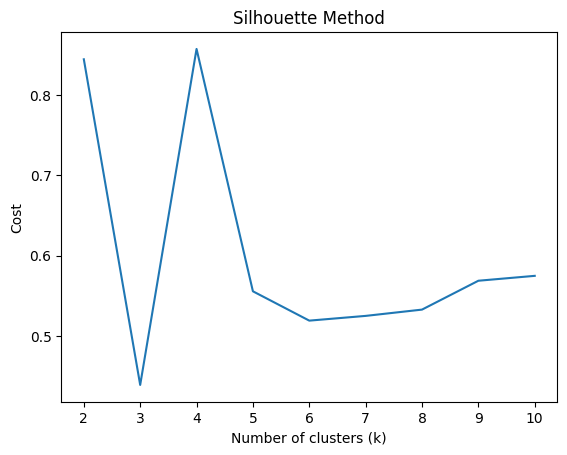

In [19]:
# Plot the cost values for different values of k
plt.plot(range(2, 11), cost)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Silhouette Method')
plt.show()

In [20]:

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator
import pickle


# Combine the 'Lat' and 'Lon' columns into a single feature vector column
assembler = VectorAssembler(inputCols=['Lat', 'Lon'], outputCol='features')
data = assembler.transform(df.select('Lat', 'Lon'))


# Split the data into training and testing sets with a 80:20 ratio
(trainingData, testData) = data.randomSplit([0.8, 0.2], seed=0)

# Train  K-means clustering model on the training set
kmeans = KMeans(k=5, seed=0)
model = kmeans.fit(trainingData)

# Predict the cluster labels for the testing set
predictions = model.transform(testData)



In [21]:
# Save the trained model to a file
model.write().overwrite().save("kmeans_model")

# Convert the PySpark KMeans model object into a Python object
pickle_model = {'clusterCenters': model.clusterCenters(), 'k': model.getK()}

# Write the Python KMeans model object to a pickle file
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(pickle_model, f)
